In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import yfinance as yf

# Download stock data
ticker = "AAPL"
start_date = "2018-01-01"
end_date = "2023-06-23"
data = yf.download(ticker, start=start_date, end=end_date)

# Prepare the data
ts = data['Close']

# Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1]

p_val = test_stationarity(ts)

if p_val > 0.05:
    # If non-stationary, difference the series
    ts_diff = ts.diff().dropna()
    p_val = test_stationarity(ts_diff)
    d = 1
    if p_val > 0.05:
        ts_diff = ts.diff().diff().dropna()
        p_val = test_stationarity(ts_diff)
        d = 2

print(f"\nd = {d}")


[*********************100%%**********************]  1 of 1 completed

ADF Statistic: -0.3683182697522504
p-value: 0.9152556228455202
ADF Statistic: -10.628683675343767
p-value: 5.283078990947532e-19
d = 1


In [45]:
# Fit ARIMA model
model = ARIMA(ts_diff, order=(2,1,3))
results = model.fit()
print(results.summary())

# Forecast
forecast = results.forecast(steps=30)
# help(forecast)
print(forecast)

c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1376
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -3036.165
Date:                Fri, 28 Jun 2024   AIC                           6084.330
Time:                        22:52:11   BIC                           6115.688
Sample:                             0   HQIC                          6096.063
                               - 1376                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8541      0.012   -148.447      0.000      -1.879      -1.830
ar.L2         -0.9734      0.012    -79.034      0.000      -0.998      -0.949
ma.L1          0.8387      0.054     15.542      0.0

c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


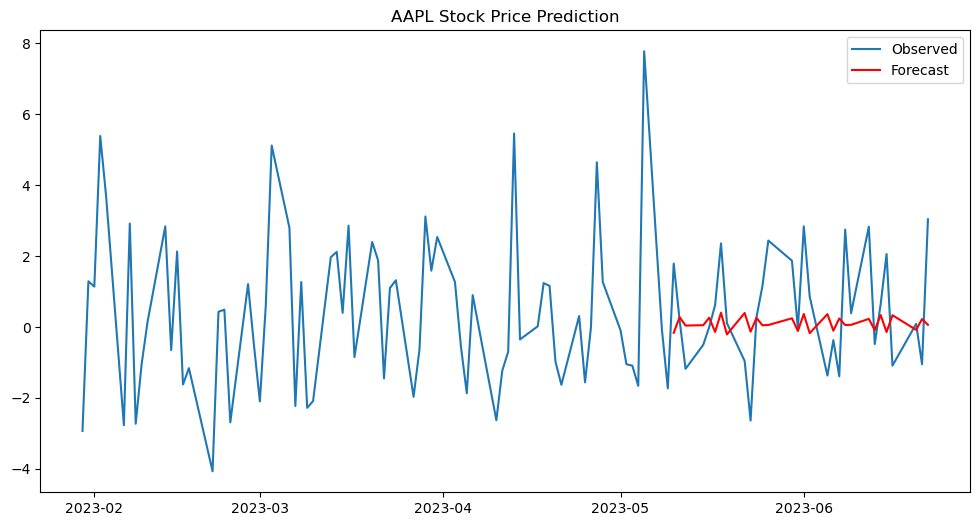

Mean Squared Error: 2.4180161166412764


In [46]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(ts.index[-100:], ts_diff.values[-100:], label='Observed')
plt.plot(ts.index[-30:], forecast.values, color='r', label='Forecast')
# plt.fill_between(forecast.index, 
#                  forecast.iloc[:, 0], 
#                  forecast.iloc[:, 1], 
#                  color='pink', alpha=0.3)
plt.title(f'{ticker} Stock Price Prediction')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(ts.diff().dropna()[-30:], forecast)
print(f'Mean Squared Error: {mse}')

Suggested d value: 0


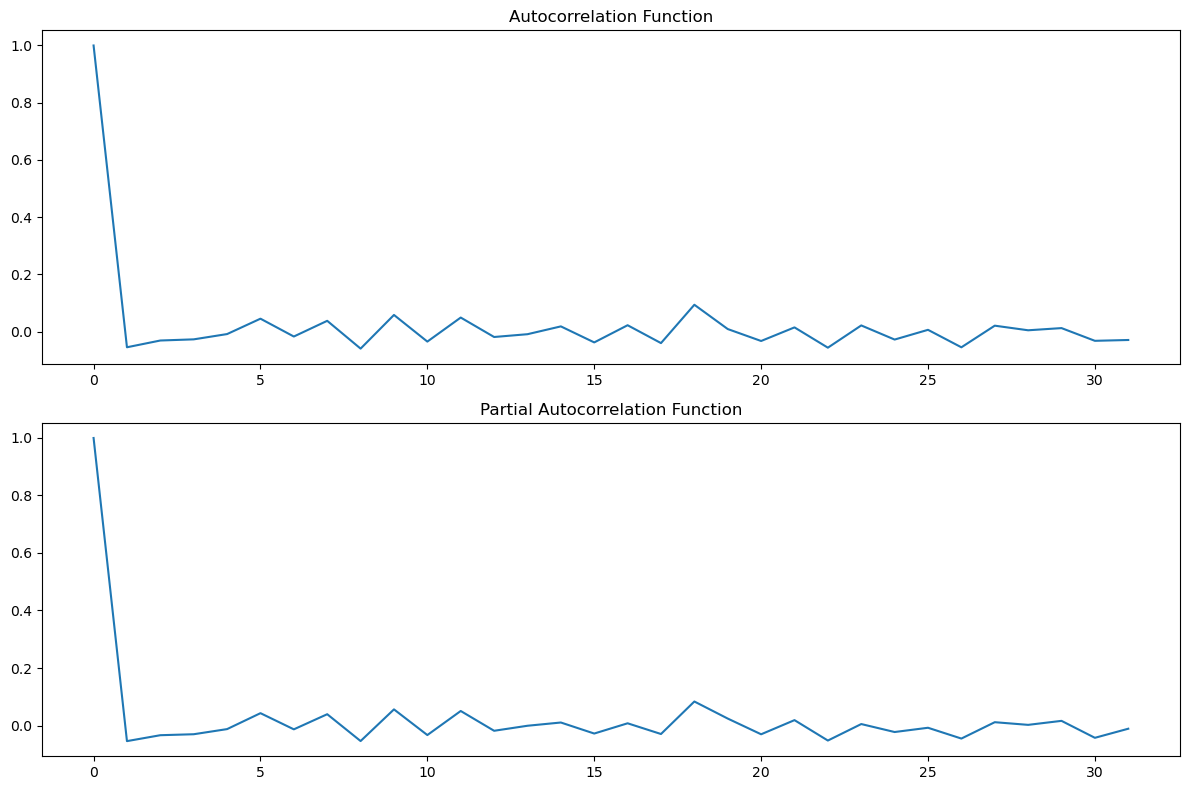

c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

def find_d_value(timeseries):
    d = 0
    while True:
        result = adfuller(timeseries)
        if result[1] < 0.05:
            break
        timeseries = timeseries.diff().dropna()
        d += 1
    return d, timeseries

def plot_acf_pacf(timeseries):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
    acf_values = acf(timeseries)
    pacf_values = pacf(timeseries)
    ax1.plot(acf_values)
    ax1.set_title('Autocorrelation Function')
    ax2.plot(pacf_values)
    ax2.set_title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()

def grid_search_arima(timeseries, p_range, d_range, q_range):
    best_aic = float('inf')
    best_order = None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(timeseries, order=(p,d,q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p,d,q)
                except:
                    continue
    return best_order

# Assuming 'ts' is your time series data
d, stationary_ts = find_d_value(ts_diff)
print(f"Suggested d value: {d}")

plot_acf_pacf(stationary_ts)

# Grid search for best p and q (assuming d is known)
best_order = grid_search_arima(ts, range(0,6), [d], range(0,6))
print(f"Best ARIMA order based on grid search: {best_order}")

# Alternatively, use auto_arima for automatic parameter selection
model = auto_arima(ts, start_p=0, start_q=0, max_p=5, max_q=5, m=1, d=None, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True)
print(f"Best ARIMA order based on auto_arima: {model.order}")